In [2]:
#########################################################################################
# purpose: want to check if the 2nd peak around 15 ms observed in the 5 nA rtds data    #
#          will be the same in terms of its position on the time scale and amplitude    #
#          when we increase the input current                                           #
#########################################################################################

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter  # Import ScalarFormatter
import uproot
sys.path.append("../")
import saq


Welcome to JupyROOT 6.28/06


In [7]:
# Define the list of file paths
root_file_paths = [
   '/home/wwz/saq_analysis/calibration/10_16_2023_5nA_random_order/10_16_2023_10_08_04.root', #5 nA
   '/home/wwz/saq_analysis/calibration/10_16_2023_5nA_random_order/10_16_2023_10_22_48.root', 
   '/home/wwz/saq_analysis/calibration/10_16_2023_5nA_random_order/10_16_2023_10_12_49.root', 
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_10_34_22.root', #10 nA
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_10_37_12.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_10_38_23.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_10_41_17.root', #20 nA
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_10_42_41.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_10_43_45.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_10_51_55.root', #30 nA
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_10_53_07.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_10_54_15.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_16_14_52.root', #40 nA
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_16_18_21.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_16_19_48.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_16_25_12.root', #50 nA
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_16_28_01.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_16_2023_16_29_25.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_17_2023_13_42_05.root', #75 nA
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_17_2023_13_44_02.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_17_2023_13_45_19.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_17_2023_13_48_43.root', #100 nA
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_17_2023_13_49_57.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_17_2023_13_54_18.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_17_2023_14_24_59.root', #200 nA
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_17_2023_14_25_53.root',
   '/home/wwz/saq_analysis/calibration/10_16_2023_diff_current/10_17_2023_14_26_43.root'
]

# Initialize lists to store data for each file
timestamps_list = []
masks_list = []

# Define constants
clock_rate = 30.3e6
nn = 0
cutoff = (2**32) - 1
loop_time = cutoff / clock_rate

j = 1

real_channel =[2, 16, 128]*9
print(real_channel)

reset_rate_bfcut=[] # to store the reset rates for ch2, 5 and 8 at all current before any cut
reset_rate_afcut=[] # to store the rest rates for ch 2, 5, and 8 after lower cut

# Iterate through each root file
for k, root_file_path in enumerate(root_file_paths):
    # Open the ROOT file
    file = uproot.open(root_file_path)

    # Access the tree from the ROOT file
    tree = file["tt"]  # 'tt' is the name of the data tree in the root file

    # Convert the tree data into a dictionary
    data = tree.arrays(library="np")

    # Get timestamps from the data
    timestamps = data["Timestamp"]
    mask = data["ChMask"]

    #print(j, ", original rtds: ", len(timestamps))
    #print(len(mask))

    #print(timestamps[:10])
    #print(mask[:10])
    filtered_timestamps = [timestamps[i] for i in range(5,len(timestamps)) if mask[i] == real_channel[k]]


    #print(j, ", filtered rtds: ", len(filtered_timestamps))
    #print(filtered_timestamps[:10])

    # Initialize an array to store time in seconds
    time_sec = np.zeros(len(filtered_timestamps))
    rtd_sec =[]
    filtered_rtd_sec=[]

    j = j+1

    # Convert the individual entries to show the time in seconds
    for i in range(len(filtered_timestamps)):
        time_sec[i] = filtered_timestamps[i] / clock_rate + (nn * loop_time)
        if i > 0 and filtered_timestamps[i] < filtered_timestamps[i - 1]:
            nn += 1
            time_sec[i] = float(filtered_timestamps[i] / clock_rate) + float(nn * loop_time)
    
    
    rtd_sec = np.diff(time_sec) #original rtds without any cut
    filtered_rtd_sec = [diff for diff in rtd_sec if diff > 5e-5] #rtds after lower cut at 5e-5 s

    print("rtd_sec length: ", len(rtd_sec), ", filtered_rtd_sec length: ", len(filtered_rtd_sec))

    reset_rate_bfcut.append(len(time_sec)/(time_sec[-1]-time_sec[0]))
    reset_rate_afcut.append(len(filtered_rtd_sec)/(time_sec[-1]-time_sec[0]))
    
    print(time_sec[0], ", ", time_sec[-1], ",", time_sec[-1]-time_sec[0], ",", len(time_sec), ", ", len(time_sec)/(time_sec[-1]-time_sec[0]))
    print(time_sec[0], ", ", time_sec[-1], ",", time_sec[-1]-time_sec[0], ",", len(filtered_rtd_sec), ", ", len(filtered_rtd_sec)/(time_sec[-1]-time_sec[0]))


    # Store the time_sec array in a list
    timestamps_list.append(time_sec)
    masks_list.append(data["ChMask"])

    nn=0

print(reset_rate_bfcut)

[2, 16, 128, 2, 16, 128, 2, 16, 128, 2, 16, 128, 2, 16, 128, 2, 16, 128, 2, 16, 128, 2, 16, 128, 2, 16, 128]
rtd_sec length:  17302 , filtered_rtd_sec length:  12601
0.00568986798679868 ,  29.83834696369637 , 29.83265709570957 , 17303 ,  580.0019738264768
0.00568986798679868 ,  29.83834696369637 , 29.83265709570957 , 12601 ,  422.3894626473695
rtd_sec length:  11505 , filtered_rtd_sec length:  10365
0.005855676567656766 ,  29.54527382838284 , 29.539418151815184 , 11506 ,  389.5134271388132
0.005855676567656766 ,  29.54527382838284 , 29.539418151815184 , 10365 ,  350.8870739000347
rtd_sec length:  15793 , filtered_rtd_sec length:  13032
0.013067425742574258 ,  29.86015092409241 , 29.847083498349836 , 15794 ,  529.1639298986519
0.013067425742574258 ,  29.86015092409241 , 29.847083498349836 , 13032 ,  436.62557518293215
rtd_sec length:  28490 , filtered_rtd_sec length:  22055
0.003502970297029703 ,  29.5982697359736 , 29.594766765676567 , 28491 ,  962.7039883633516
0.003502970297029703 , 

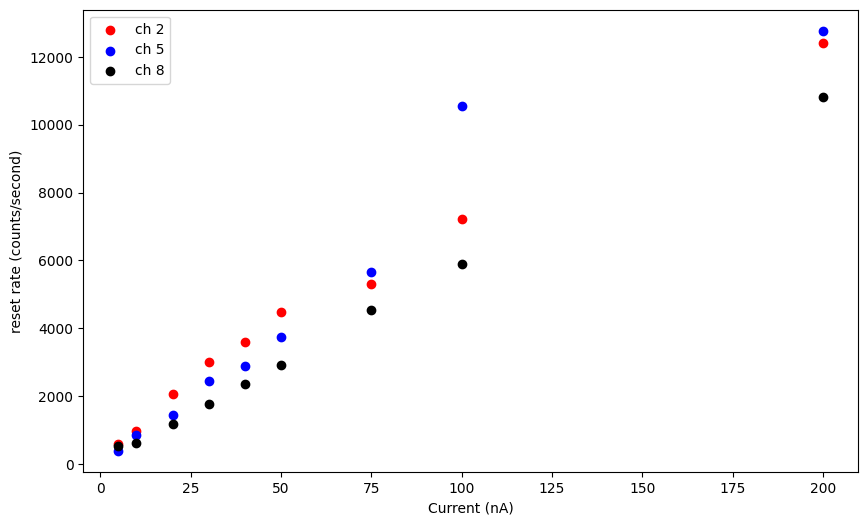

In [8]:
#################################################################################################################
# Plot the reset rate vs. current for Ch 2, 5, and 8 and perform a linear fit for each data set before any cut
#################################################################################################################

#Correct the reset rate for the following two data sets. The error in the original data was due to the 'cross talk' from the previous run for the same channel
#reset_rate_bfcut[2] = 535.56
#reset_rate_bfcut[13] = 2901.66
#print(reset_rate_bfcut)

#Assign the reset rate data to the corresonding channel
ch2_reset_rate_bfcut = reset_rate_bfcut[::3] #reset_rate[0], [3], [6], ..., belong to ch2 
ch5_reset_rate_bfcut = reset_rate_bfcut[1::3] #reset_rate[1], [4], [7], ..., belong to ch5
ch8_reset_rate_bfcut = reset_rate_bfcut[2::3] #reset_rate[2], [5], [8], ..., belong to ch8

x_current =[5, 10, 20, 30, 40, 50, 75, 100, 200]

#print(ch2_reset_rate)
#print(ch5_reset_rate)
#print(ch8_reset_rate)

#print(len(ch8_reset_rate))

plt.figure(figsize=(10, 6))
plt.scatter(x_current, ch2_reset_rate_bfcut, label='ch 2', color='red')
plt.scatter(x_current, ch5_reset_rate_bfcut, label='ch 5', color='blue')
plt.scatter(x_current, ch8_reset_rate_bfcut, label='ch 8', color='black')

plt.xlabel("Current (nA)")
plt.ylabel("reset rate (counts/second)")
plt.legend()
plt.show()

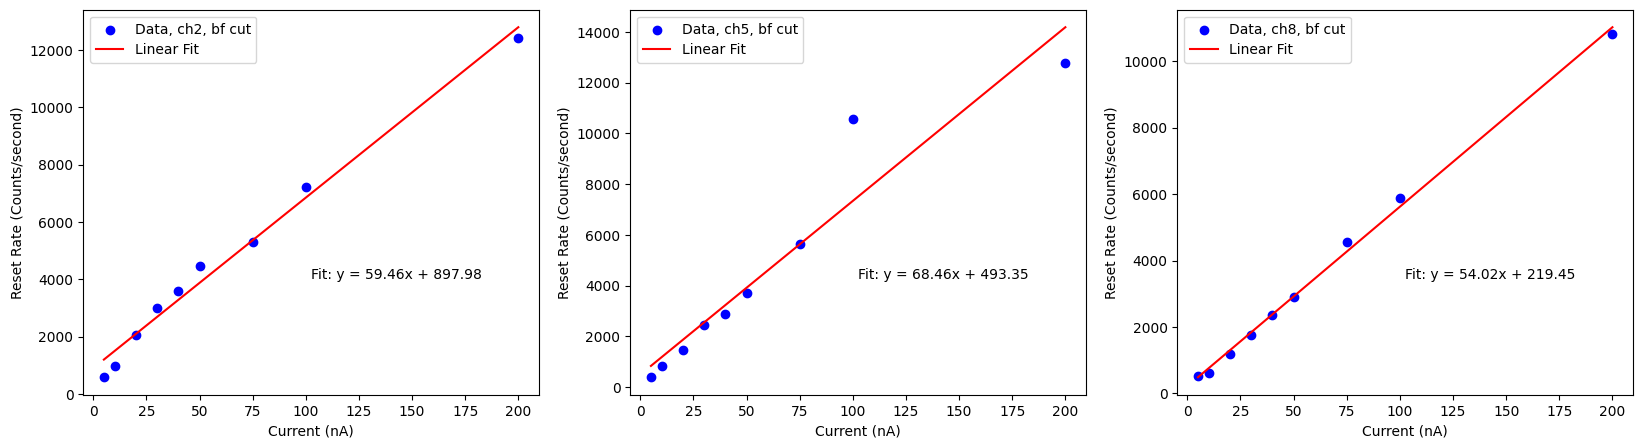

In [9]:

# Create a 1x3 subplot grid
fig, axs = plt.subplots(1, 3, figsize=(20, 5)) 

ch=[2, 5, 8]

j=2

# Linear fit and plotting for each group
for i, group in enumerate([ch2_reset_rate_bfcut, ch5_reset_rate_bfcut, ch8_reset_rate_bfcut]):
    y = group

    # Perform linear fit using numpy.polyfit. It is a polynomial of a specified degree to a set of data points.
    fit_params = np.polyfit(x_current, y, 1) # 1 is the degree of the polynominal fit. i.e. a linear fit
    fit_line = np.poly1d(fit_params)

    #print(fit_params[0], ", ", fit_params[1])

    # Plot the scatter plot
    axs[i].scatter(x_current, y, label=f'Data, ch{j}, bf cut', color='blue')
    
    # Plot the fitted line
    axs[i].plot(x_current, fit_line(x_current), label='Linear Fit', color='red')

     # Annotate the plot with the fit equation
    equation_text = f'Fit: y = {fit_params[0]:.2f}x + {fit_params[1]:.2f}'
    axs[i].annotate(equation_text, (0.5, 0.3), xycoords='axes fraction', fontsize=10, color='black')


    axs[i].set_xlabel('Current (nA)')
    axs[i].set_ylabel('Reset Rate (Counts/second)')
    axs[i].legend()
    j= j+3

plt.show()


[422.3894626473695, 350.8870739000347, 436.62557518293215, 745.2331074147528, 714.5265418825057, 599.787138317012, 1358.4357849991345, 1345.6406483528508, 1156.4624922059593, 2118.966095556238, 2109.0941052332505, 1756.0139809271682, 2937.466291712435, 2660.2004054916183, 2359.2305877784756, 3667.5587939466577, 3355.952108231906, 2891.817875553287, 4475.43270392216, 4905.5977903650955, 4538.207807638397, 6146.582310377563, 7617.7142158921615, 5881.688041643069, 10802.08695922862, 10779.568955172517, 10772.421244737812]
[422.3894626473695, 745.2331074147528, 1358.4357849991345, 2118.966095556238, 2937.466291712435, 3667.5587939466577, 4475.43270392216, 6146.582310377563, 10802.08695922862]
[350.8870739000347, 714.5265418825057, 1345.6406483528508, 2109.0941052332505, 2660.2004054916183, 3355.952108231906, 4905.5977903650955, 7617.7142158921615, 10779.568955172517]
[436.62557518293215, 599.787138317012, 1156.4624922059593, 1756.0139809271682, 2359.2305877784756, 2891.817875553287, 4538.2

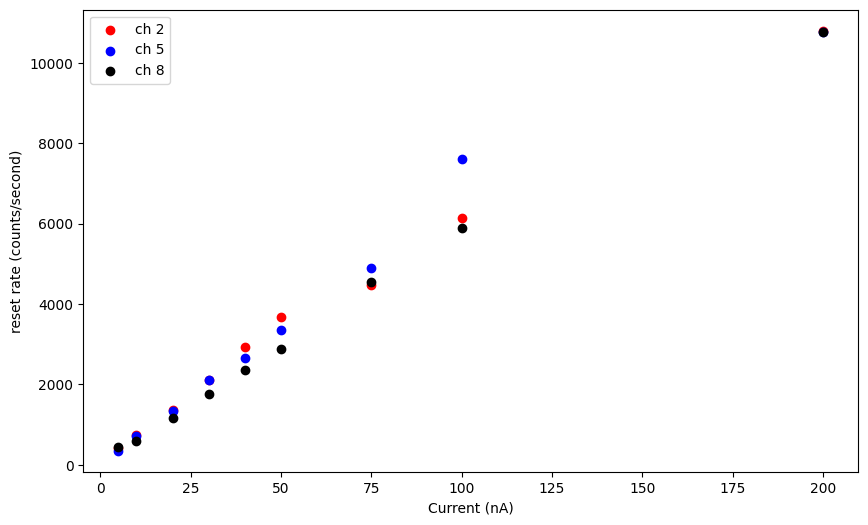

In [10]:
#################################################################################################################
# Plot the rtd rate vs. current for Ch 2, 5, and 8 and perform a linear fit for each data set after a lower cut
#################################################################################################################

#Correct the reset rate for the following two data sets. The error in the original data was due to the 'cross talk' from the previous run for the same channel
#reset_rate_afcut[2] = 441.86
#reset_rate_afcut[13] = 2666.34
print(reset_rate_afcut)

#Assign the reset rate data to the corresonding channel
ch2_reset_rate_afcut = reset_rate_afcut[::3] #reset_rate[0], [3], [6], ..., belong to ch2 
ch5_reset_rate_afcut = reset_rate_afcut[1::3] #reset_rate[1], [4], [7], ..., belong to ch5
ch8_reset_rate_afcut = reset_rate_afcut[2::3] #reset_rate[2], [5], [8], ..., belong to ch8

x_current =[5, 10, 20, 30, 40, 50, 75, 100, 200]

print(ch2_reset_rate_afcut)
print(ch5_reset_rate_afcut)
print(ch8_reset_rate_afcut)

#print(len(ch8_reset_rate))

plt.figure(figsize=(10, 6))
plt.scatter(x_current, ch2_reset_rate_afcut, label='ch 2', color='red')
plt.scatter(x_current, ch5_reset_rate_afcut, label='ch 5', color='blue')
plt.scatter(x_current, ch8_reset_rate_afcut, label='ch 8', color='black')

plt.xlabel("Current (nA)")
plt.ylabel("reset rate (counts/second)")
plt.legend()
plt.show()

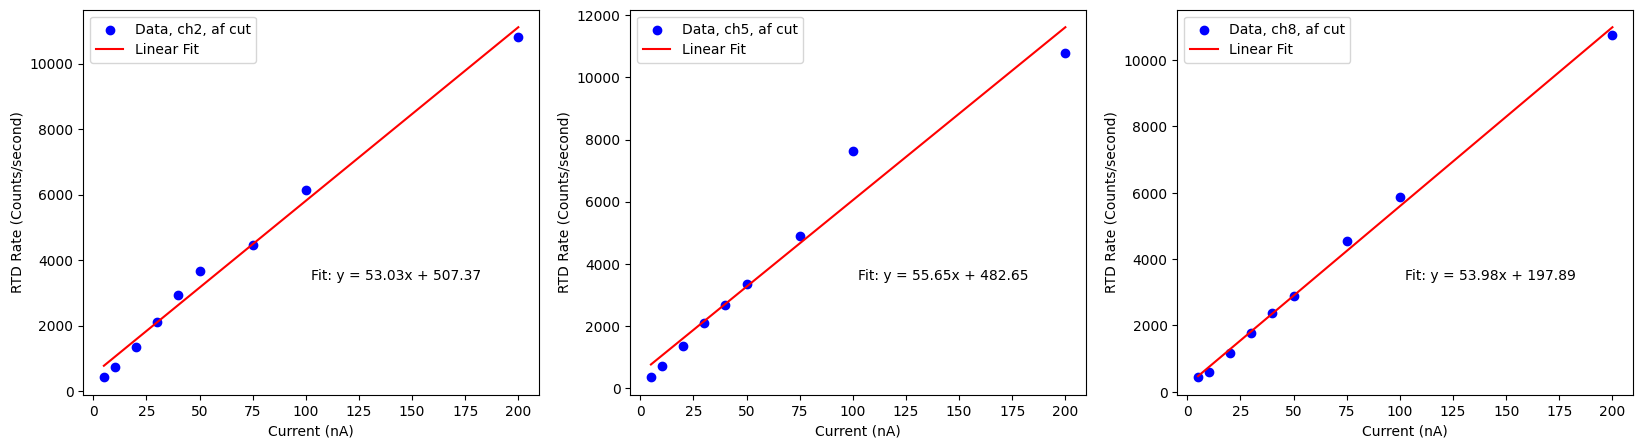

In [11]:

# Create a 1x3 subplot grid
fig, axs = plt.subplots(1, 3, figsize=(20, 5)) 

ch=[2, 5, 8]

j=2

# Linear fit and plotting for each group
for i, group in enumerate([ch2_reset_rate_afcut, ch5_reset_rate_afcut, ch8_reset_rate_afcut]):
    y = group

    # Perform linear fit using numpy.polyfit. It is a polynomial of a specified degree to a set of data points.
    fit_params = np.polyfit(x_current, y, 1) # 1 is the degree of the polynominal fit. i.e. a linear fit
    fit_line = np.poly1d(fit_params)

    #print(fit_params[0], ", ", fit_params[1])

    # Plot the scatter plot
    axs[i].scatter(x_current, y, label=f'Data, ch{j}, af cut', color='blue')
    
    # Plot the fitted line
    axs[i].plot(x_current, fit_line(x_current), label='Linear Fit', color='red')

     # Annotate the plot with the fit equation
    equation_text = f'Fit: y = {fit_params[0]:.2f}x + {fit_params[1]:.2f}'
    axs[i].annotate(equation_text, (0.5, 0.3), xycoords='axes fraction', fontsize=10, color='black')


    axs[i].set_xlabel('Current (nA)')
    axs[i].set_ylabel('RTD Rate (Counts/second)')
    axs[i].legend()
    j= j+3

plt.show()

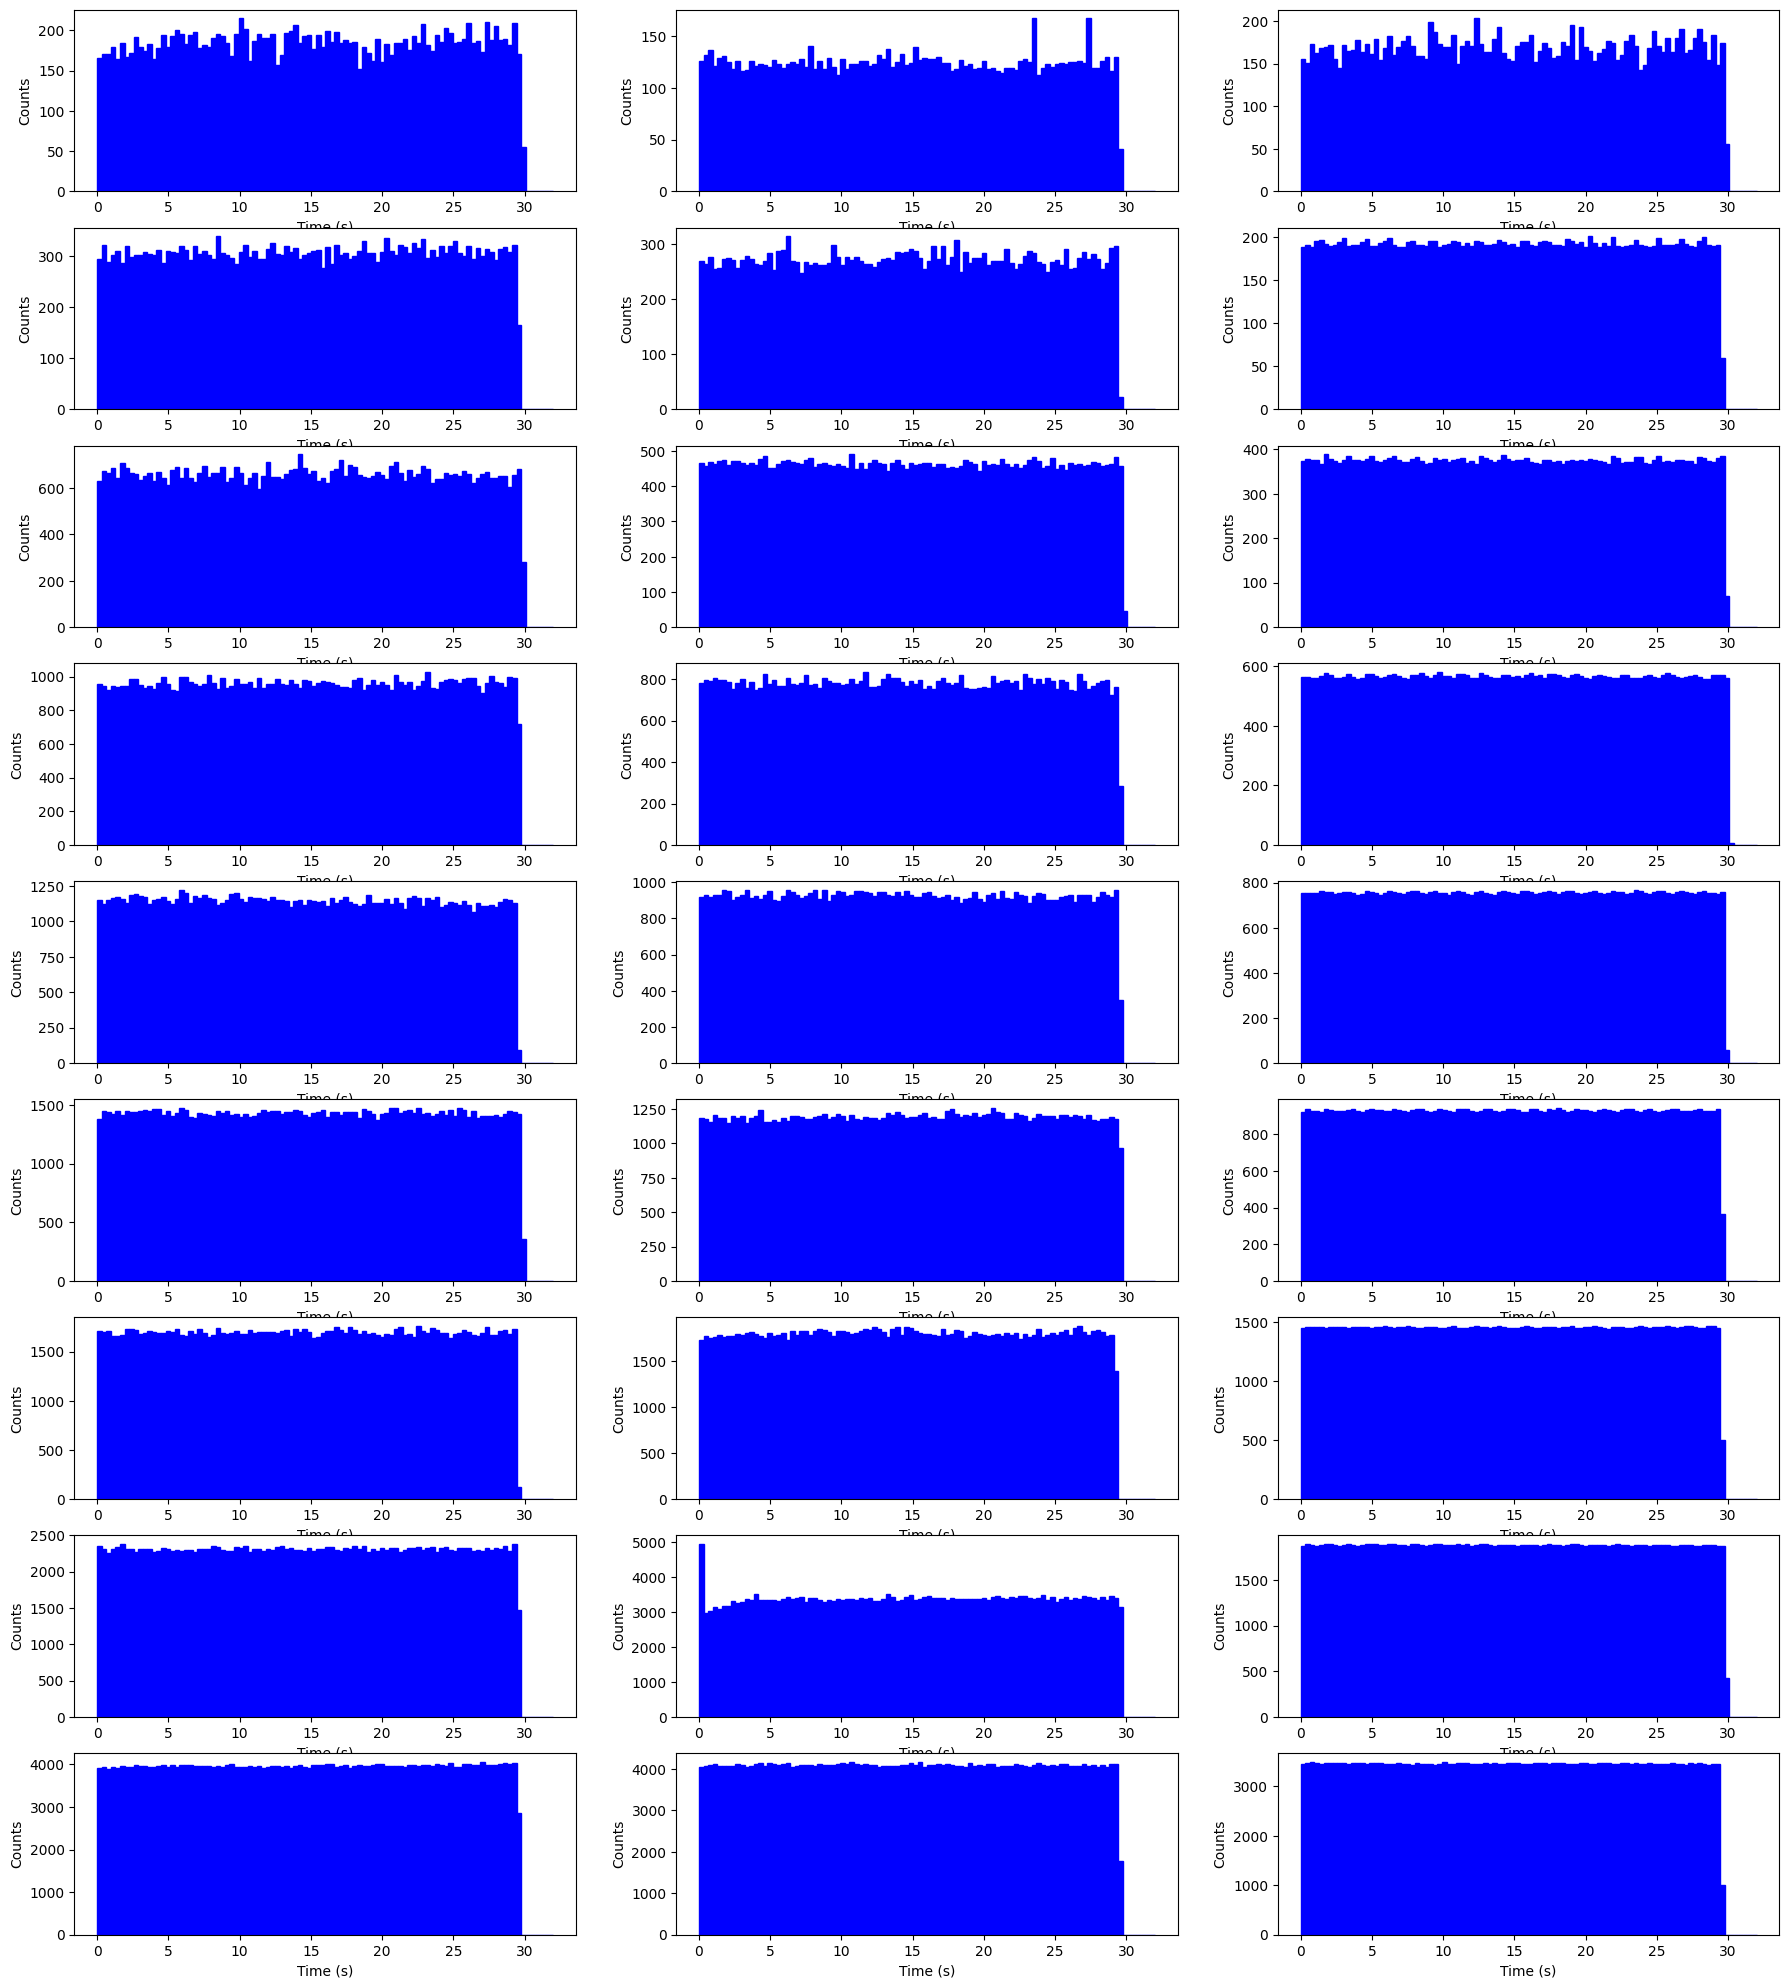

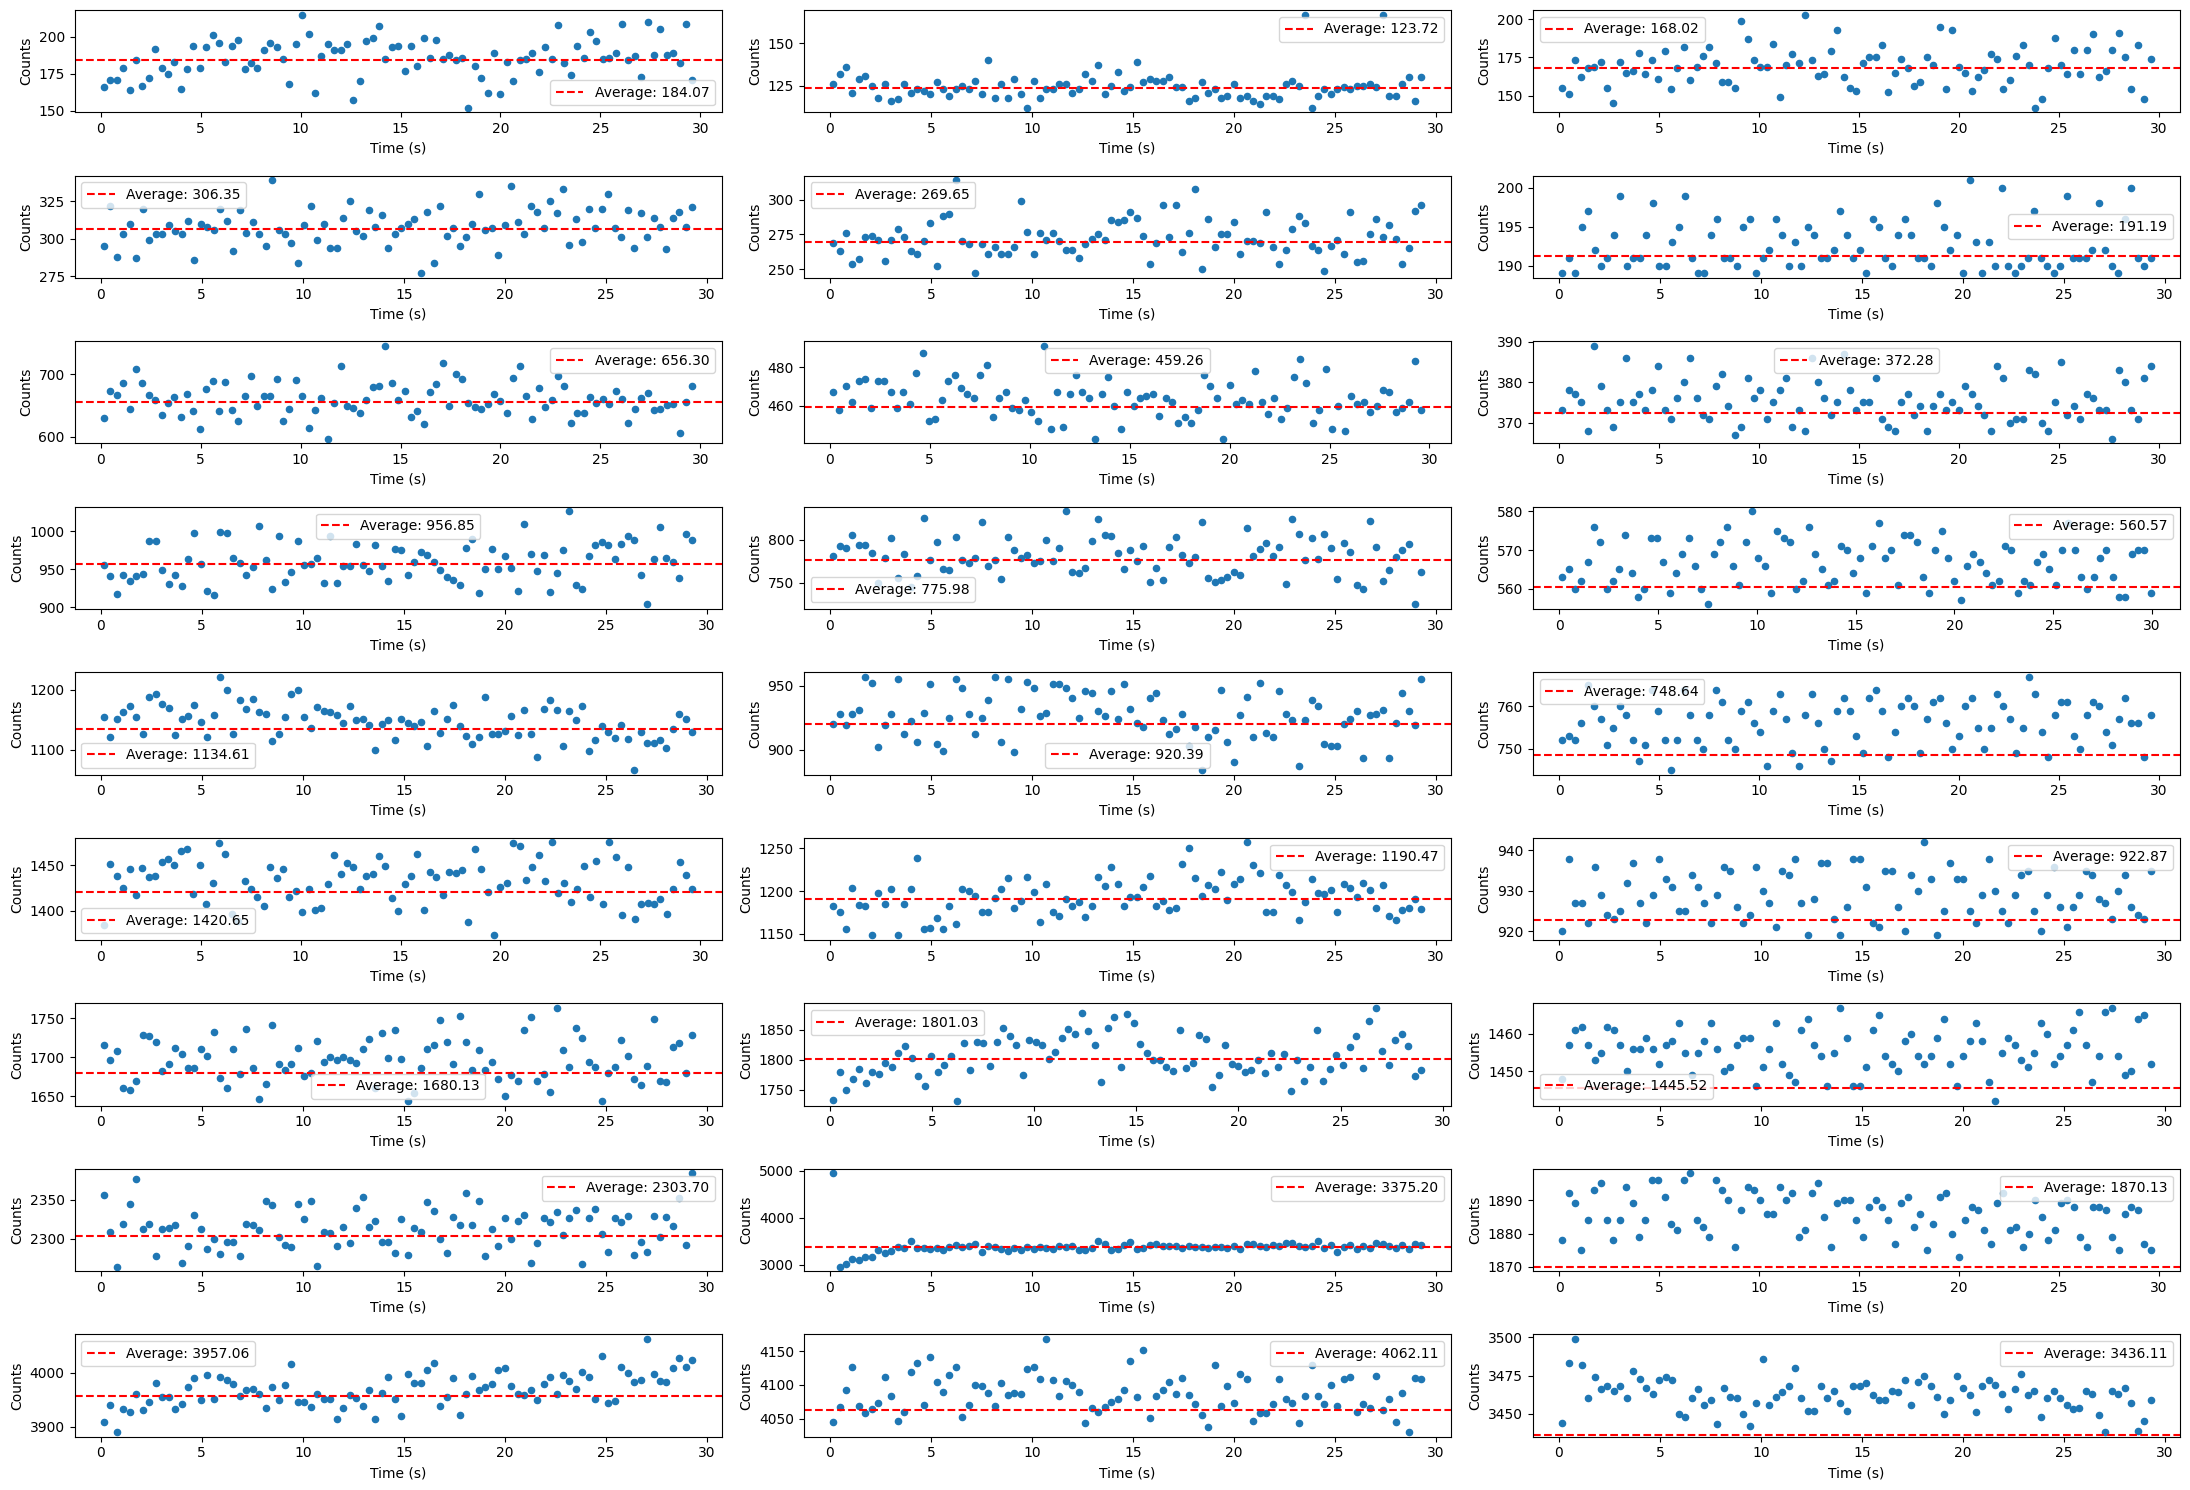

In [13]:
# Create a figure with a 3x5 grid of subplots
fig, axes = plt.subplots(9, 3, figsize=(22, 25))

# Create lists to store bin content from each histogram
bin_contents = []
bin_center=[]

# Create lists to store averages for each channel
averages = []

# Define the desired range for each histogram
histogram_ranges = [(0, 32), (0, 32), (142, 175), (0, 32), (0, 32),
                    (0, 32), (0, 32), (0, 32), (0, 32), (0, 32),(0, 32),
                      (0, 32), (0, 32), (142, 172), (0, 32), (0, 32),(0, 32), (0, 32),(0, 32), 
                      (0, 32), (0, 32), (0, 32),(0, 32), (0, 32),(0, 32), (0, 32),(0, 32)]

# Loop through your data and create histograms
for i in range(27):
    row = i // 3 #Integer division (//) in Python returns the whole number part of the division result.
    col = i % 3 #The modulo operator (%) in Python returns the remainder of the division operation. 
    ax = axes[row, col]

    # Create the histogram and plot for the "timestamp" data
    hist, bins, _ = ax.hist(timestamps_list[i], range=[0, 32], bins=100, color='blue', alpha=1, edgecolor='blue')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Counts')
    #ax.set_title(f'Ch {i + 2}')

  # Store the bin content in the bin_contents list
    bin_contents.append(hist)
    bin_center.append(bins)

# Create a new 3x5 subplot grid to display the scatter plots of bin content
fig2, axes2 = plt.subplots(9, 3, figsize=(22, 15))

for i, content in enumerate(bin_contents):
    # Calculate the center of each bin
    bin_centers = (bin_center[i][:-1] + bin_center[i][1:]) / 2

    # Filter out bins with zero bin content
    non_zero_bins = content != 0
    avg = np.mean(content[non_zero_bins])
    averages.append(avg)

    # Scatter plot of non-zero bin content in the new subplot grid with specified range
    row = i // 3
    col = i % 3
    ax2 = axes2[row, col]
    ax2.scatter(bin_centers[non_zero_bins][:-1], content[non_zero_bins][:-1], marker='o', s=20)

    # Draw the average line on the scatter plot
    ax2.axhline(y=averages[i], color='red', linestyle='--', label=f'Average: {averages[i]:.2f}')

    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Counts')
    #ax2.set_title(f'Ch {i + 2}')
    ax2.legend()

plt.tight_layout()
plt.show()

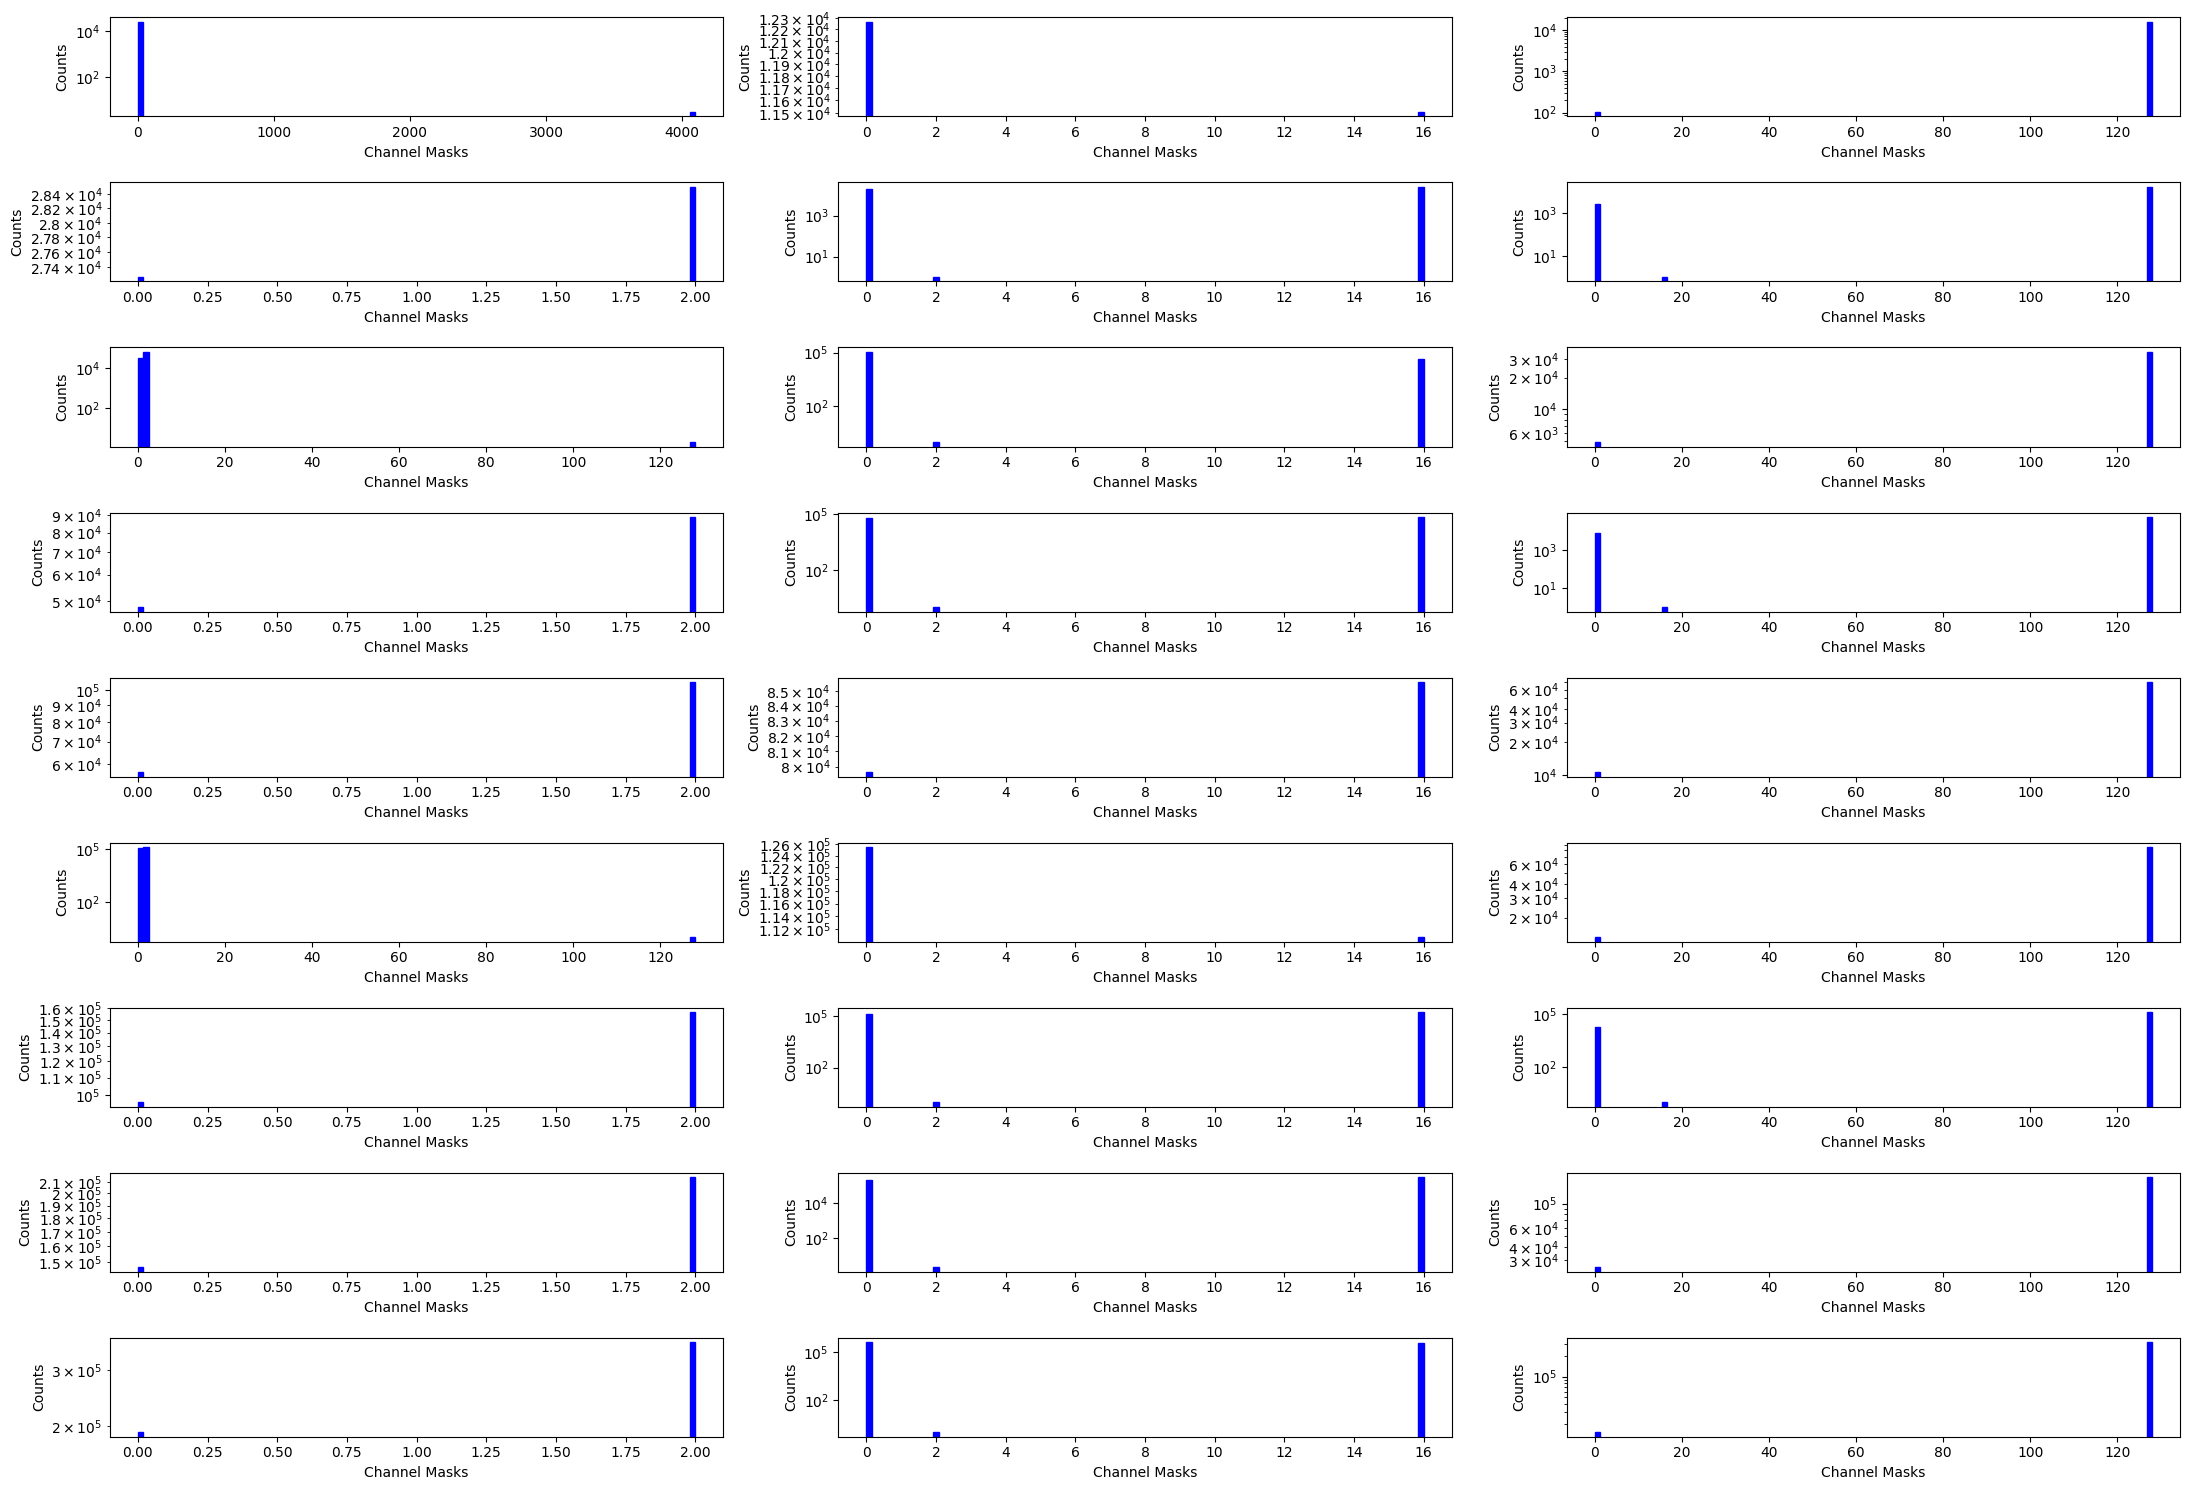

In [14]:
# Create a figure with a 3x5 grid of subplots
fig, axes = plt.subplots(9, 3, figsize=(22, 15))

# Loop through your data and create histograms
for i in range(27):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Create the histogram and plot for the "timestamp" data
    hist, bins, _ = ax.hist(masks_list[i], bins=100, color='blue', alpha=1, edgecolor='blue')
    ax.set_xlabel('Channel Masks')
    ax.set_ylabel('Counts')
    ax.set_yscale('log')
    #ax.set_xscale('log')
    #ax.set_title(f'Ch {i + 2}')

plt.tight_layout()
plt.show()

27
12601
5nA ,mean rtd:  0.002366944139537358  ,std rtd:  0.005020913014029631 ,mean charge:  11.83472069768679  ,std charge:  25.104565070148155
10364
5nA ,mean rtd:  0.0028426054392394077  ,std rtd:  0.00539351939905118 ,mean charge:  14.213027196197038  ,std charge:  26.967596995255903
13032
5nA ,mean rtd:  0.0022873139613685135  ,std rtd:  0.004616958402045864 ,mean charge:  11.436569806842567  ,std charge:  23.084792010229318
22055
10nA  ,mean rtd:  0.0013415409391313176  ,std rtd:  0.003406059754825102 ,mean charge:  13.415409391313176  ,std charge:  34.06059754825102
21049
10nA  ,mean rtd:  0.0013992444331135576  ,std rtd:  0.0033939868870861605 ,mean charge:  13.992444331135577  ,std charge:  33.9398688708616
17703
10nA  ,mean rtd:  0.001667256520263109  ,std rtd:  0.0036066259867978405 ,mean charge:  16.67256520263109  ,std charge:  36.0662598679784
40625
20nA  ,mean rtd:  0.0007355975254633186  ,std rtd:  0.0018860589601039843 ,mean charge:  14.711950509266373  ,std charge:  

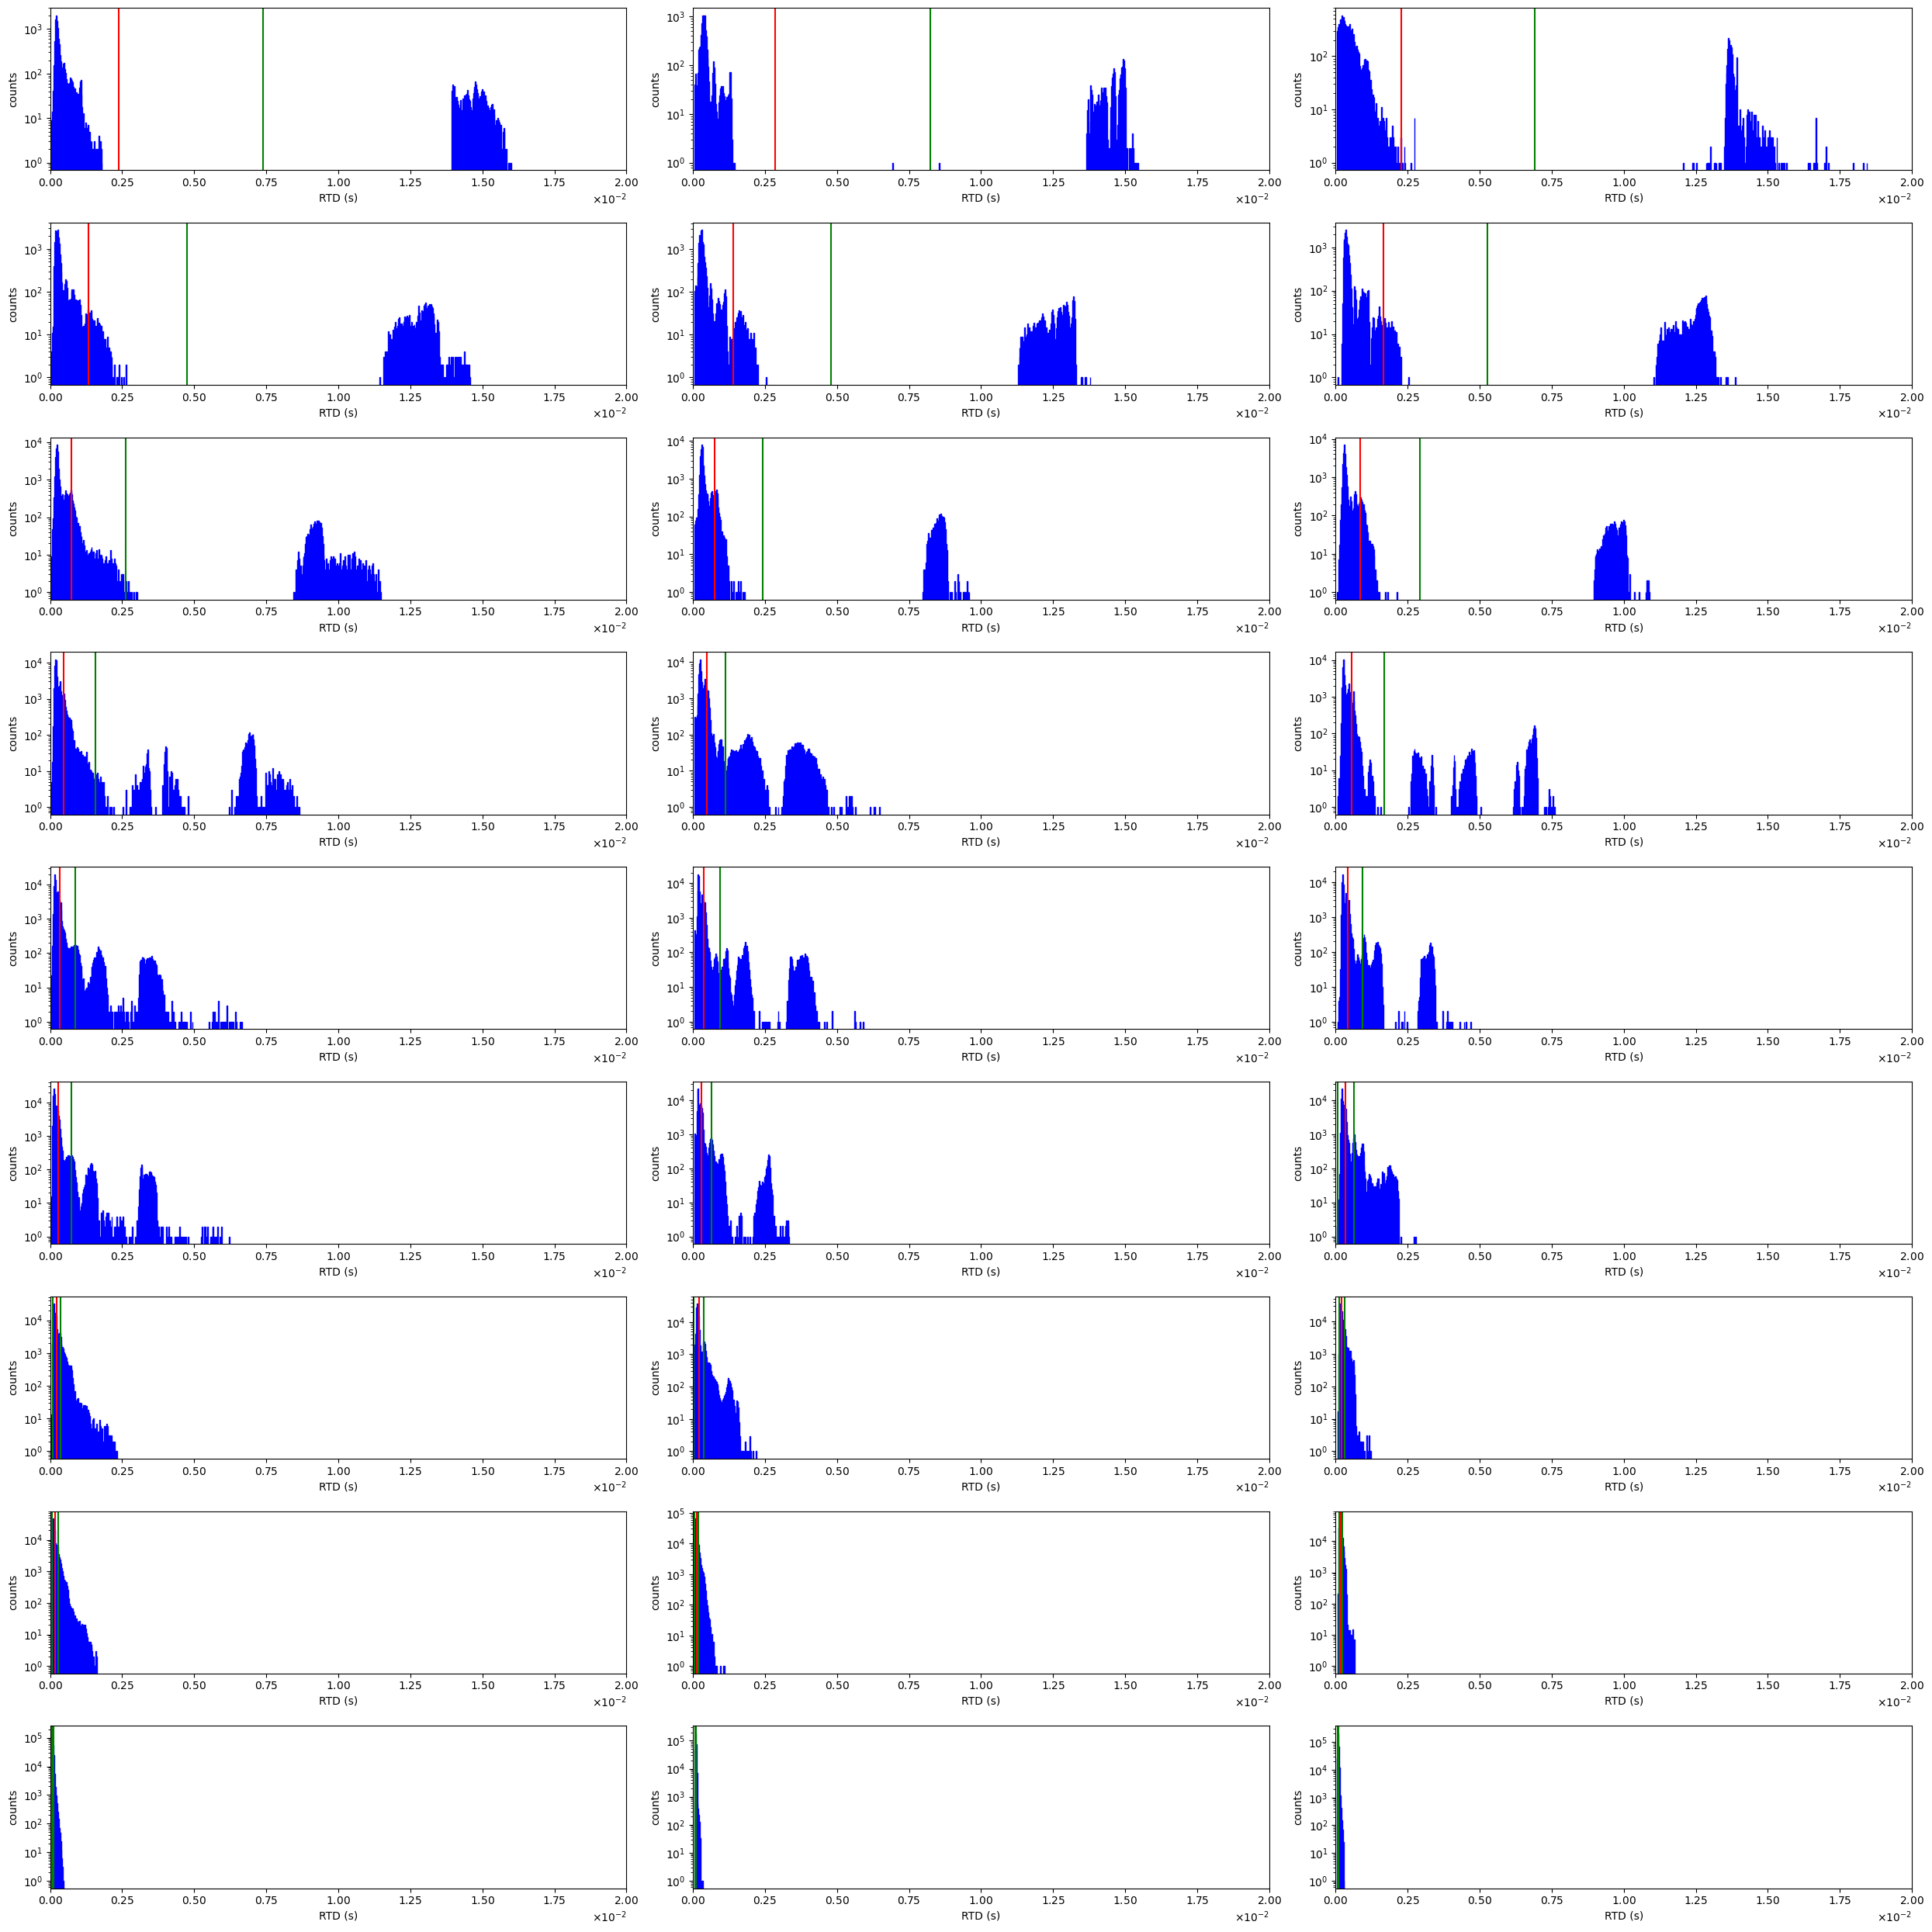

In [15]:
# Create a figure with a 3x5 grid of subplots
fig, axes = plt.subplots(9, 3, figsize=(25, 25))

mean_charge = [] # To store the mean charge per reset for each channel
std_charge = [] # To store the standard deviation for the mean charge per reset for each channel

print(len(timestamps_list))

# Iterate through each time data array and plot the time differences
for i in range(len(timestamps_list)):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Calculate time differences between adjacent data points
    rtd = np.diff(timestamps_list[i])

    # Set lower and upper cutoffs for the data
    lower_cutoff = 5e-5  
    upper_cutoff = 5e-2  

# Apply conditional filtering to keep only the data within the desired range
    filtered_rtd = rtd[(rtd >= lower_cutoff) & (rtd <= upper_cutoff)]
    print(len(filtered_rtd))

    mean_rtd = np.mean(filtered_rtd)
    std_rtd = np.std(filtered_rtd)

#Calcuate the mean charge per reset for each channel
    if(row==0):
      mean_Q = mean_rtd * 5000 # The charge is in pC since rtd is in s and current is in pA
      std_Q = std_rtd * 5000

    if(row==1):
      mean_Q = mean_rtd * 1e4 # The charge is in pC since rtd is in s and current is in pA
      std_Q = std_rtd * 1e4

    if(row==2):
      mean_Q = mean_rtd * 2e4 # The charge is in pC since rtd is in s and current is in pA
      std_Q = std_rtd * 2e4
    
    if(row==3):
      mean_Q = mean_rtd * 3e4 # The charge is in pC since rtd is in s and current is in pA
      std_Q = std_rtd * 3e4

    if(row==4):
      mean_Q = mean_rtd * 4e4 # The charge is in pC since rtd is in s and current is in pA
      std_Q = std_rtd * 4e4
  
    if(row==5):
      mean_Q = mean_rtd * 5e4 # The charge is in pC since rtd is in s and current is in pA
      std_Q = std_rtd * 5e4

    if(row==6):
      mean_Q = mean_rtd * 7.5e4 # The charge is in pC since rtd is in s and current is in pA
      std_Q = std_rtd * 7.5e4
  
    if(row==7):
      mean_Q = mean_rtd * 1e5 # The charge is in pC since rtd is in s and current is in pA
      std_Q = std_rtd * 1e5
    
    if(row==8):
      mean_Q = mean_rtd * 2e5 # The charge is in pC since rtd is in s and current is in pA
      std_Q = std_rtd * 2e5

    mean_charge.append(mean_Q)
    std_charge.append(std_Q)

    if(row==0):
        print("5nA", ",mean rtd: ",  mean_rtd, " ,std rtd: ", std_rtd, ",mean charge: ", mean_Q, " ,std charge: ", std_Q)
    if(row==1):
        print("10nA", " ,mean rtd: ",  mean_rtd, " ,std rtd: ", std_rtd, ",mean charge: ", mean_Q, " ,std charge: ", std_Q)
    if(row==2):
        print("20nA", " ,mean rtd: ",  mean_rtd, " ,std rtd: ", std_rtd, ",mean charge: ", mean_Q, " ,std charge: ", std_Q)
    if(row==3):
        print("30nA", " ,mean rtd: ",  mean_rtd, " ,std rtd: ", std_rtd, ",mean charge: ", mean_Q, " ,std charge: ", std_Q)
    if(row==4):
        print("40nA", " ,mean rtd: ",  mean_rtd, " ,std rtd: ", std_rtd, ",mean charge: ", mean_Q, " ,std charge: ", std_Q)
    if(row==5):
        print("50nA", " ,mean rtd: ",  mean_rtd, " ,std rtd: ", std_rtd, ",mean charge: ", mean_Q, " ,std charge: ", std_Q)
    if(row==6):
        print("75nA", " ,mean rtd: ",  mean_rtd, " ,std rtd: ", std_rtd, ",mean charge: ", mean_Q, " ,std charge: ", std_Q)
    if(row==7):
        print("100nA", " ,mean rtd: ",  mean_rtd, " ,std rtd: ", std_rtd, ",mean charge: ", mean_Q, " ,std charge: ", std_Q)
    if(row==8):
        print("200nA", " ,mean rtd: ",  mean_rtd, " ,std rtd: ", std_rtd, ",mean charge: ", mean_Q, " ,std charge: ", std_Q)

 
      # Create a histogram of time differences
    ax.hist(filtered_rtd, bins=2000, range=(0, 0.05), color='blue', alpha=1, edgecolor='blue')
    ax.axvline(mean_rtd, color = 'red')
    ax.axvline(mean_rtd-std_rtd , color = 'green')
    ax.axvline(mean_rtd+std_rtd, color = 'green')

    # Configure the x-axis formatter to use scientific notation
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))  # Apply scientific notation

     # Add titles (labels) to x and y axes
    ax.set_xlabel('RTD (s)')  # Replace with your desired x-axis label
    ax.set_ylabel('counts')  # Replace with your desired y-axis label

    # Define your desired x-axis range
    x_min = 0  # Replace with your desired minimum x-axis value
    x_max = 0.02  # Replace with your desired maximum x-axis value

     # Set the x-axis range
    ax.set_xlim(x_min, x_max)
    ax.set_yscale('log')
    #.set_title(f'Ch {i + 2}')

plt.tight_layout()
plt.show()

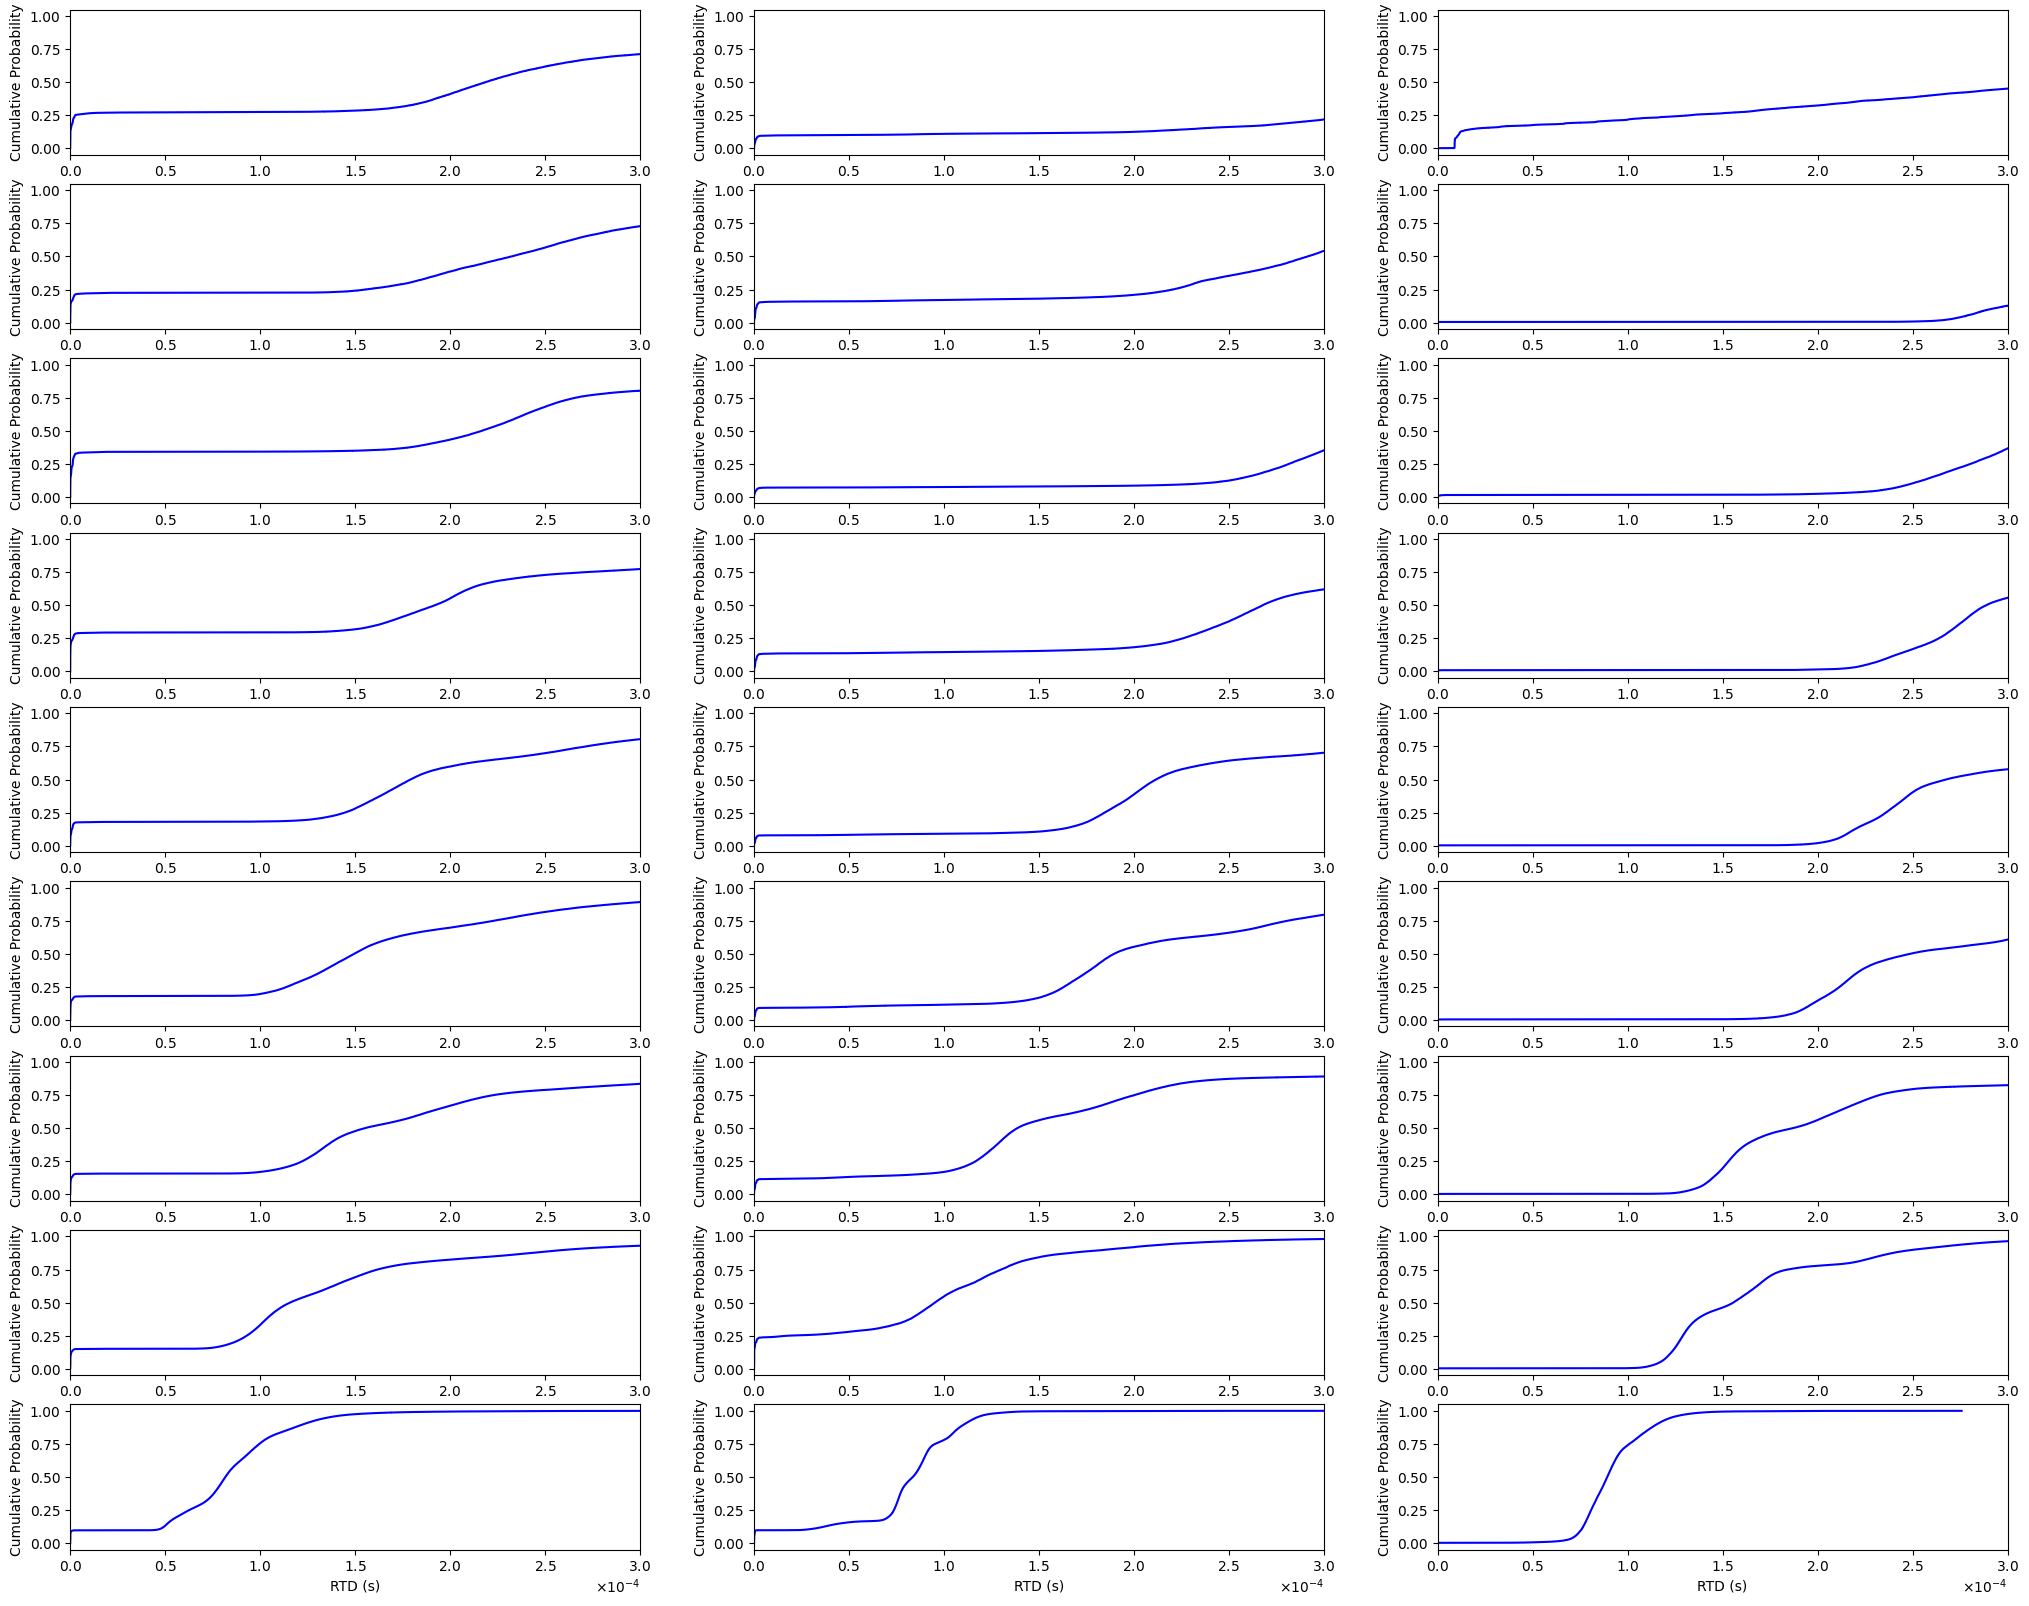

In [15]:
# Create a figure with a 3x5 grid of subplots
fig, axes = plt.subplots(9, 3, figsize=(25, 20))

# Iterate through each time data array and plot the time differences
for i in range(len(timestamps_list)):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # Calculate time differences between adjacent data points
    rtd = np.diff(timestamps_list[i])

    # Set lower and upper cutoffs for the data
    lower_cutoff = 0  # Example lower cutoff
    upper_cutoff = 5e-2  # Example upper cutoff

# Apply conditional filtering to keep only the data within the desired range
    filtered_rtd = rtd[(rtd >= lower_cutoff) & (rtd <= upper_cutoff)]

 # Calculate the cumulative distribution
    sorted_rtd = np.sort(filtered_rtd)
    cumulative_prob = np.arange(1, len(sorted_rtd) + 1) / len(sorted_rtd)

    ax.plot(sorted_rtd, cumulative_prob, color='blue')

    
    # Add labels and a title
    ax.set_xlabel('RTD (s)')
    ax.set_ylabel('Cumulative Probability')
    #ax.set_title(f'Ch {i+2}')

    # Configure the x-axis formatter to use scientific notation
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    # Define your desired x-axis range
    x_min = 0  # Replace with your desired minimum x-axis value
    x_max = 0.0003 # Replace with your desired maximum x-axis value

    # Set the x-axis range
    ax.set_xlim(x_min, x_max)

[11.833869106637696, 14.213027196197038, 11.435323571101925, 13.413633464529624, 13.99192676559818, 16.676520296181646, 14.711444786145547, 14.86048599621617, 17.292702703530257, 14.151525227438048, 14.216875130162222, 17.083519670700383, 13.609492462800983, 15.027395088980251, 16.95445972949131, 13.626063267016878, 14.878971642311312, 17.290256961712082, 16.750364583419245, 15.233587538809152, 16.527487983697696, 16.26044921557291, 12.935251412258037, 17.002222748021858, 18.138065375092822, 18.014899311068728, 18.534609502301898]
[11.833869106637696, 13.413633464529624, 14.711444786145547, 14.151525227438048, 13.609492462800983, 13.626063267016878, 16.750364583419245, 16.26044921557291, 18.138065375092822]
26.128
0.6157533332405668 ,  0.6437182589291292


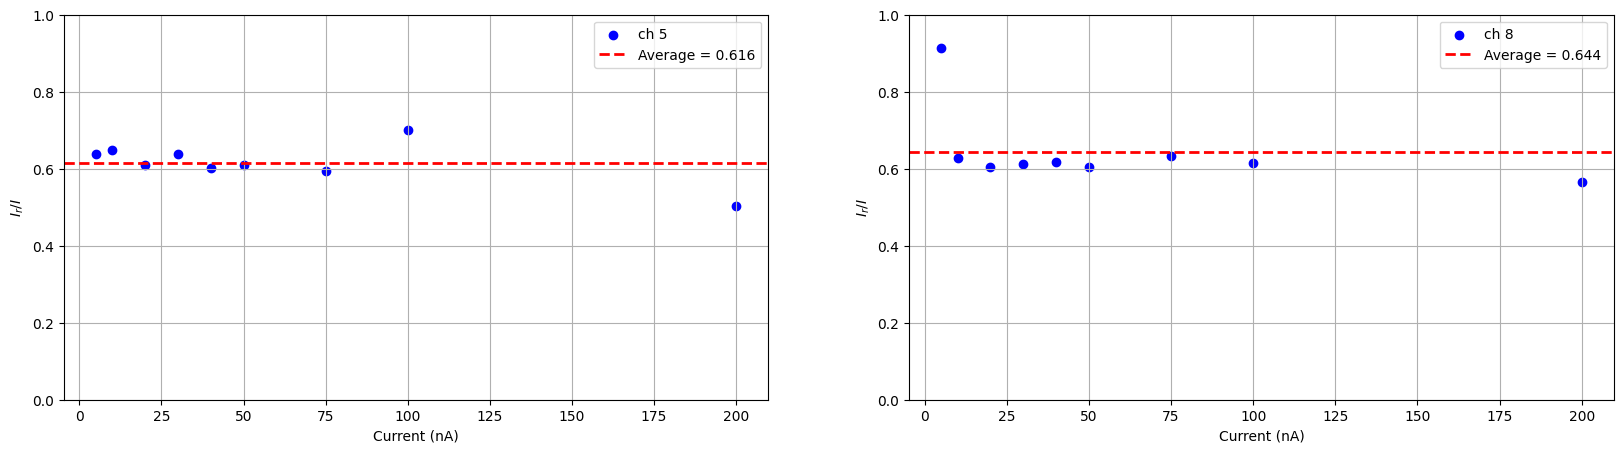

In [14]:
print(mean_charge)

ch2_meanCharge=mean_charge[::3]
ch5_meanCharge=mean_charge[1::3]
ch8_meanCharge=mean_charge[2::3]

print(ch2_meanCharge)

charge_CVdd =[26.128, 9.06, 10.46] 

print(charge_CVdd[0])

ch2_ratio = [] # The ratio of reconstructed current to original current for Ch2 at different current
ch5_ratio = [] 
ch8_ratio = []

for i in range(len(ch2_meanCharge)):
    #ch2_ratio.append(charge_CVdd[0]/ch2_meanCharge[i])
    ch5_ratio.append(charge_CVdd[1]/ch5_meanCharge[i])
    ch8_ratio.append(charge_CVdd[2]/ch8_meanCharge[i])

#print(ch5_ratio)

ch5_ratio_mean = np.mean(ch5_ratio)
ch8_ratio_mean = np.mean(ch8_ratio)

print(ch5_ratio_mean, ", ", ch8_ratio_mean)

fig, axs = plt.subplots(1, 2, figsize=(20, 5)) 

# Plot each group in a separate subplot
#axs[0].scatter(x_current, ch2_ratio, label='ch 2', color='blue')
axs[0].scatter(x_current, ch5_ratio, label='ch 5', color='blue')
axs[1].scatter(x_current, ch8_ratio, label='ch 8', color='blue')

axs[0].axhline(ch5_ratio_mean, color='red', linestyle='--', label='Average = 0.616', linewidth=2)
axs[1].axhline(ch8_ratio_mean, color='red', linestyle='--', label='Average = 0.644', linewidth=2)


# Set common labels and title
for ax in axs:
    ax.set_xlabel('Current (nA)')
    ax.set_ylabel('$I_{r}/I$')
    ax.set_ylim(0, 1)
    ax.grid(True)
    ax.legend()

plt.show()
